# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JBF4QD_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JBF4QD_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [6]:
ds.as_numpy_iterator().next()['label']

np.int64(2)

In [7]:
ds.take(1)

<_TakeDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

# 2. Vis Data and Build Dataset

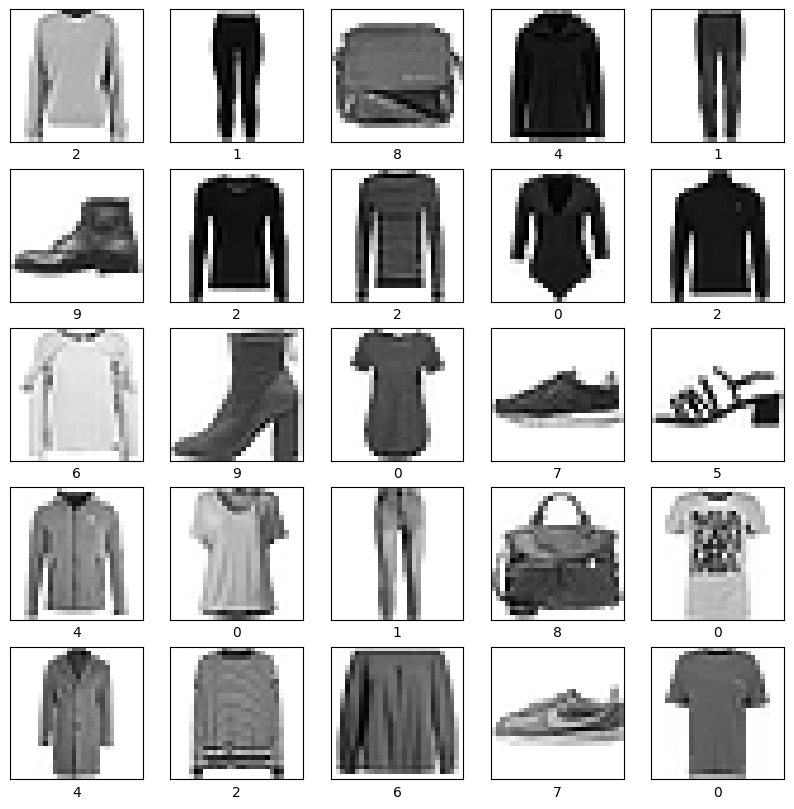

In [8]:
import numpy as np

dataIterator = ds.as_numpy_iterator()
def get_images_and_labels(dataIterator, num_samples=25):
    images = []
    labels = []
    for _ in range(num_samples):
        data = dataIterator.next()
        images.append(data['image'])
        labels.append(data['label'])
    return np.array(images), np.array(labels)
images, labels = get_images_and_labels(dataIterator, 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [9]:
def scale_images(data):
    image = data['image']
    return image/ 255

In [10]:
ds = tfds.load('fashion_mnist', split='train')      # Load the Fashion MNIST training dataset (60,000 images)
ds = ds.map(scale_images)                           # Apply image scaling (e.g., normalize pixel values to 0–1)
ds = ds.cache()                                     # Cache data in memory or disk after preprocessing
ds = ds.shuffle(60000)                              # Randomly shuffle the dataset with buffer size = 60,000
ds = ds.batch(128)                                  # Group the dataset into batches of 128 samples
ds = ds.prefetch(64)                                # Prefetch 64 batches asynchronously to improve performance


In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modeling Component

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Dropout, UpSampling2D

### 3.2 Build Generator

In [13]:
def build_generator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Dense(7 * 7 * 128, input_dim=128)) # Fully connected layer transforming 128-dim noise to 7*7*128 units
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Reshape((7, 7, 128)))               # Reshape the output vector to a 3D tensor with shape 7x7x128

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (14x14)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (28x28)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128,4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128, 4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))  # Final convolutional layer with 1 filter, kernel size 4x4, 'same' padding, and sigmoid activation

    return model                                 # Return the constructed generator model


In [14]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


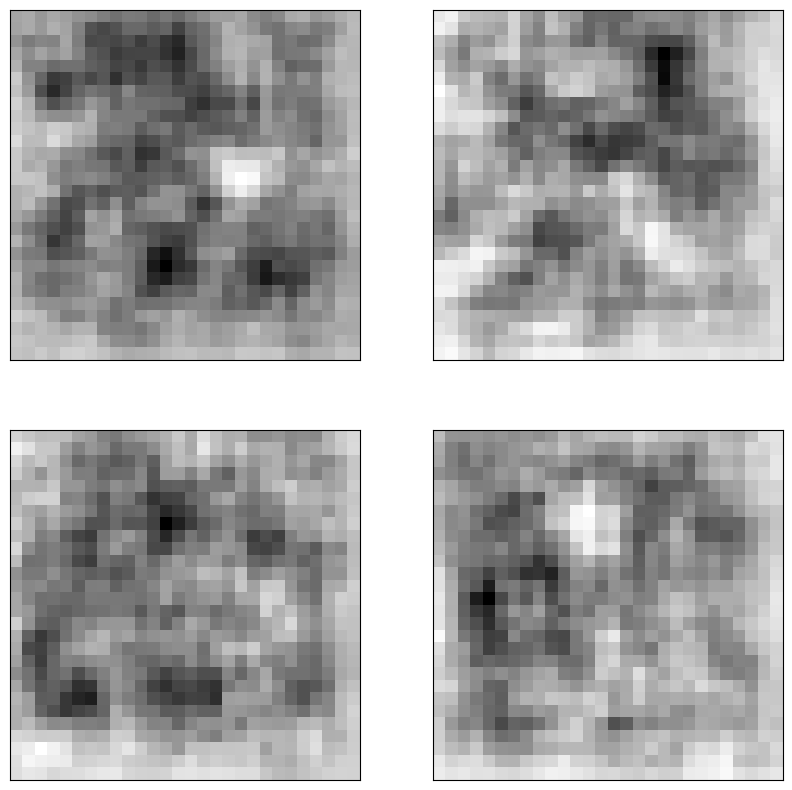

In [16]:
img = generator.predict(np.random.randn(4, 128, 1))  # Generate 4 images from random noise vectors of size 128
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i].squeeze(), cmap=plt.cm.binary)  # Display each generated image in grayscale

In [17]:
img.shape

(4, 28, 28, 1)

### 3.3 Build Descriminator

In [18]:
def build_discriminator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  # Convolutional layer with 32 filters, kernel size 5x5, input shape 28x28x1
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(64, 5))                            # Convolutional layer with 64 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(128, 5))                           # Convolutional layer with 128 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(256, 5))                           # Convolutional layer with 256 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Flatten())                                 # Flatten the output tensor to a 1D vector
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Fully connected layer with 1 output unit and sigmoid activation for binary classification

    return model                                 # Return the constructed discriminator model

In [19]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


array([[0.4986497 ],
       [0.49836695],
       [0.49874076],
       [0.4984222 ]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimization

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [24]:
from tensorflow.keras.models import Model

In [25]:
import tensorflow as tf
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[-2.88976097e+00],
        [-1.65852085e-01],
        [ 4.98480320e-01],
        [ 2.47761941e+00],
        [-3.91667128e-01],
        [-3.65972430e-01],
        [ 3.48393559e-01],
        [ 7.53959894e-01],
        [ 1.81992567e+00],
        [ 1.28763422e-01],
        [ 1.85249299e-01],
        [-8.36786211e-01],
        [ 8.26306343e-02],
        [-8.01743269e-01],
        [ 1.41505384e+00],
        [-4.56726581e-01],
        [-1.77019000e-01],
        [ 1.47672379e+00],
        [-3.12523693e-01],
        [ 4.10619788e-02],
        [ 1.05976355e+00],
        [ 8.87621760e-01],
        [-3.91451299e-01],
        [-6.56202018e-01],
        [-4.29058135e-01],
        [ 2.05783629e+00],
        [ 6.10831678e-01],
        [-8.71075392e-02],
        [-1.93445653e-01],
        [-1.20070302e+00],
        [-6.03869200e-01],
        [ 5.69799244e-01],
        [ 1.17064202e+00],
        [-3.44551325e-01],
        [-3.46196502e-01],
  

In [26]:


class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:

            # Pass the real and fake images to the discriminator
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the outputs
            noie_real = 0.15* tf.random.uniform(tf.shape(yhat_real))
            noie_fake = -0.15* tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noie_real, noie_fake], axis=0)

            # calculate the loss for real and fake images
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply the backproapagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # calculate the loss for fake images
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply the backproapagation - nn learn
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}

In [27]:
fashgan = FashionGAN(generator, discriminator)

In [28]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [29]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

In [30]:
class ModelMonitor(Callback):
    def __init__(self, num_images = 3, latent_dim = 128):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_images, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_images):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GANImages', f'epoch_{epoch}_image_{i}.png'))

### 4.4 Train

In [33]:
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.2903 - g_loss: 6.3048
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - d_loss: 0.2797 - g_loss: 6.5876
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - d_loss: 0.2764 - g_loss: 6.4495
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - d_loss: 0.2746 - g_loss: 6.1409
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - d_loss: 0.2728 - g_loss: 5.7879
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - d_loss: 0.2721 - g_loss: 5.3819
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - d_loss: 0.2706 - g_loss: 5.0231
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - d_loss: 0.2701 - g_loss: 4.6425
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - d_loss: 0.2701 - g_loss: 4.3161
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step - d_loss: 0.2696 - g_loss: 4.0603


### 4.5 Review Performance

# 5. Test out the Generator

### 5.1 Generate Images

### 5.2 Save the Model